In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy import stats
import seaborn

In [2]:
df = pd.read_csv("Adops & Data Scientist Sample Data - Q2 Regression.csv",names = ["A","B","C"])
df.shape

(300, 3)

In [3]:
df.head() 

,A,B,C
0,0.490,-0.18,11.50
1,-1.410,-1.23,11.80
2,0.943,4.51,-3.24
3,3.570,5.07,-23.90
4,-1.700,6.91,-22.10


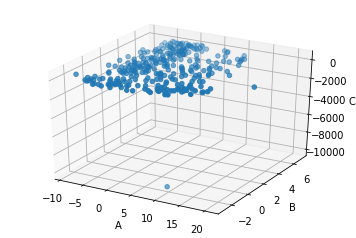

In [4]:
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter3D(df["A"],df["B"],df["C"])
ax.set_xlabel("A")
ax.set_ylabel("B")
ax.set_zlabel("C")
plt.show()

Remove outliers and replot

In [5]:
df = df[(np.abs(stats.zscore(df["C"])) < 3)]
df.shape

(299, 3)

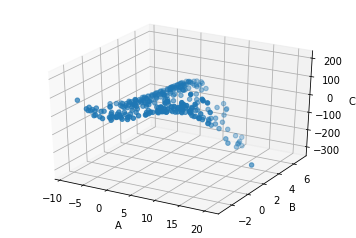

In [6]:
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter3D(df["A"],df["B"],df["C"])
ax.set_xlabel("A")
ax.set_ylabel("B")
ax.set_zlabel("C")
plt.show()

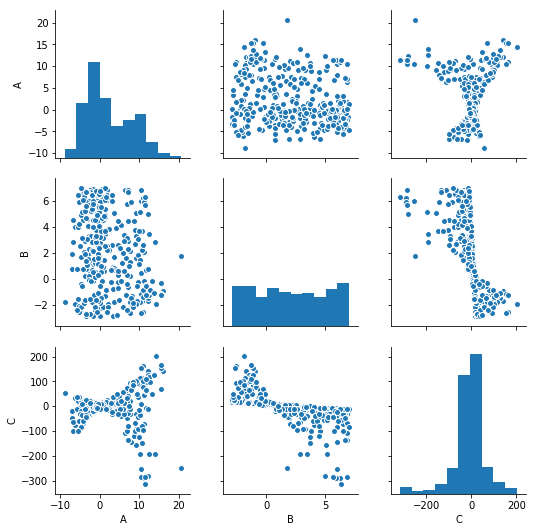

In [7]:
seaborn.pairplot(df)

Pair plots suggeust higer-order polinomial may required to explain the relationship, here I use adjusted r_sq to evaluate the model performance

First assume a simple linear model
$$
     C = \alpha + \theta_A X_A + \theta_B X_B  + \epsilon
$$


In [9]:
data = np.array(df)
A = data[:,0]
B = data[:,1]
C = data[:,-1]
X = np.concatenate((np.ones_like(C)[:,np.newaxis],data[:,:2]),axis=1)
theta = np.linalg.solve(np.dot(X.T,X),np.dot(X.T,C))

def adj_r_sq(theta, X,Y):
    Y_pred = np.dot(X,theta)
    ss_tot = sum((Y - np.mean(Y)) ** 2)
    ss_res = sum((Y - Y_pred) ** 2)
    r_sq = 1-ss_res/ss_tot
    N,k = X.shape
    return 1-(1-r_sq)*(N-1)/(N-k-1)
    
adj_r_sq(theta,X,C)

0.3878597242165026

Involve higer-order into the regression model


In [16]:
#order of 2
X2 = np.concatenate((X,(A**2)[:,np.newaxis],(B**2)[:,np.newaxis],(A*B)[:,np.newaxis]),axis=1)
theta2 = np.linalg.solve(np.dot(X2.T,X2),np.dot(X2.T,C))
adj_r_sq(theta2,X2,C)

0.7736147077078145

In [17]:
#order of 3
X3 = np.concatenate((X2,(A**3)[:,np.newaxis],(B**3)[:,np.newaxis]),axis=1)
theta3 = np.linalg.solve(np.dot(X3.T,X3),np.dot(X3.T,C))
adj_r_sq(theta3,X3,C)

0.7738690943879094

In [18]:
#order of 4
X4 = np.concatenate((X3,(A**4)[:,np.newaxis],(B**4)[:,np.newaxis]),axis=1)
theta4 = np.linalg.solve(np.dot(X4.T,X4),np.dot(X4.T,C))
adj_r_sq(theta4,X4,C)

0.7746242353414385

Order 2-4 have similar adjusted r_sq with a significant improvement over order of 1, thus I choose order of 2 to be the best model to balance model complexity and performance

In [13]:
best_model = theta2
para = ["constant","A","B","A_sq","B_sq","AB"]
print(*zip(para,best_model))

('constant', 20.670512414162097) ('A', 6.01169735541168) ('B', -12.258838945364197) ('A_sq', -0.47427193975054377) ('B_sq', 0.29809903731561344) ('AB', -2.693080669561456)


Plot the fitted plane with 3D-rotation

<IPython.core.display.Javascript object>


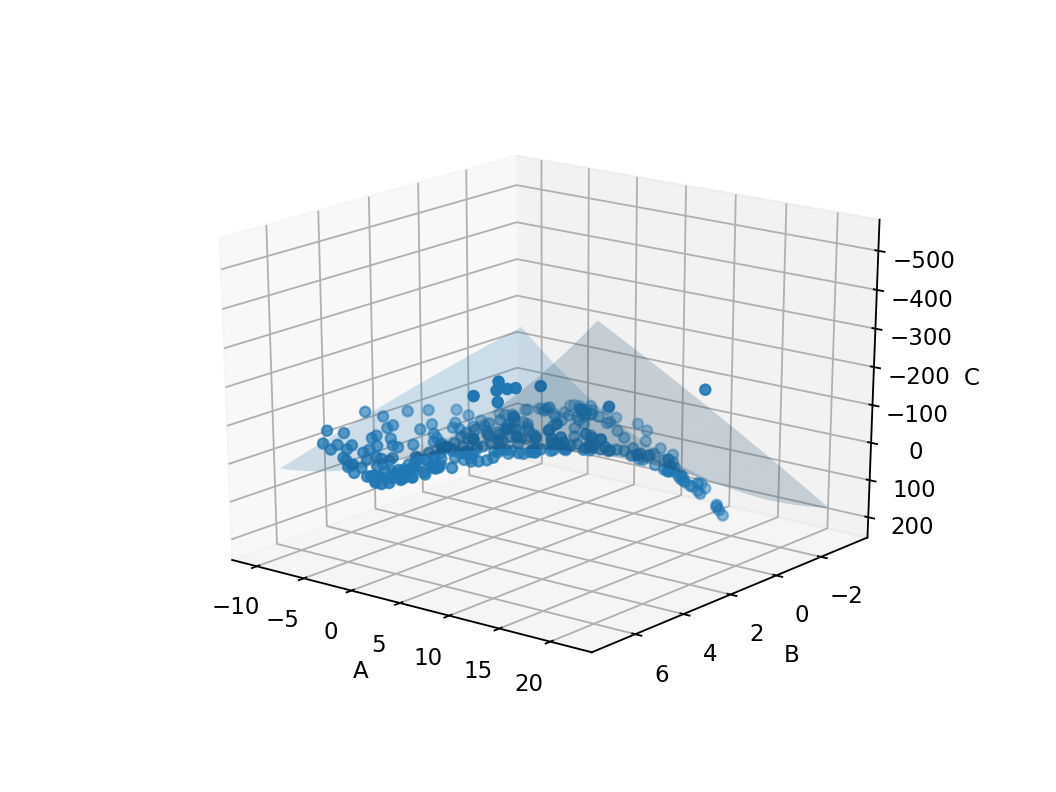

In [14]:
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection="3d")
ax.scatter3D(df["A"],df["B"],df["C"])

ax.set_xlabel("A")
ax.set_ylabel("B")
ax.set_zlabel("C")
a,b = np.meshgrid(np.arange(ax.get_xlim()[0],ax.get_xlim()[1]),np.arange(ax.get_ylim()[0],ax.get_ylim()[1]))
c_plane = np.ones_like(a)
for i in range(a.shape[0]):
    for j in range(a.shape[1]):
        c_plane[i,j] = best_model @ np.array([1,a[i,j],b[i,j],(a[i,j])**2,(b[i,j])**2,(a[i,j]*b[i,j])]) 
ax.plot_surface(a, b, c_plane, alpha=0.2)
        

for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)
plt.show()


